C:\Users\david\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


1

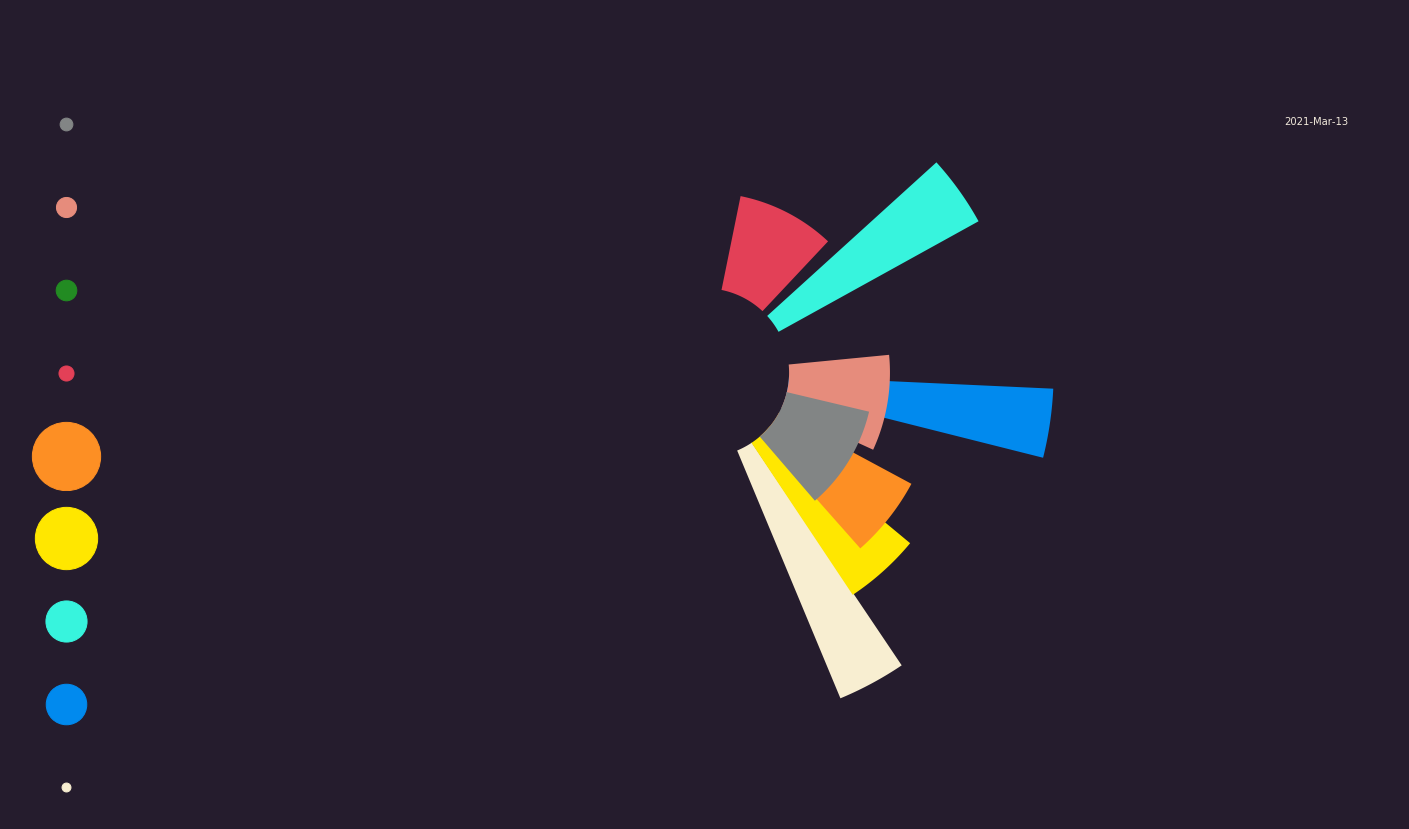

In [7]:
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ctypes

os.chdir("../data")

def load_ephemeris(filepath):
    """Load HORIZONS ephemeris data into pandas dataframe"""

    #Read in ephemeris file
    with open(filepath, "r") as ephemeris:
        lines = ephemeris.readlines()

    #Get line number with start and end of ephemeris symbol
    start = [i for i,line in enumerate(lines) if "$$SOE" in line][0]
    end = [i for i,line in enumerate(lines) if "$$EOE" in line][0]

    # Get column names as two lines before start of ephemeris data
    columns = lines[start-2].split(",")
    columns = [name.strip() for name in columns]
    columns

    # Read the lines between start and end of ephemeris symbols
    # use identified columns as column names
    ephemeris = pd.read_csv(filepath, skiprows=start+1, skipfooter=len(lines)-end, header=None, names=columns)
    return ephemeris

###################
#                 #
#    Load data    #
#                 #
###################
# Load ephemeris data
mercury = load_ephemeris("mercury.15")
venus = load_ephemeris("venus.15")

mars = load_ephemeris("mars.15")
jupiter = load_ephemeris("jupiter.15")
saturn = load_ephemeris("saturn.15")
uranus = load_ephemeris("uranus.15")
neptune = load_ephemeris("neptune.15")
pluto = load_ephemeris("pluto.15")

planets = [mercury, venus, mars, jupiter, saturn, uranus, neptune, pluto]

#Load mass and volume data
masses = pd.read_csv("planet_masses.csv")

# Colour pallete (missing Earth)
planetary_colours = [
    "#828585",
    "#e68c7c",
    
    "#e34057",
    "#fd8f24",
    "#FFE700",
    "#37f4dd",
    "#018aee",
    "#f8eed1"
]
# Colour pallete (icluding Earth)
planetary_colours9 = planetary_colours.copy()
planetary_colours9.insert(2, "forestgreen")

# Get today's date in the same calendar date format
calendarDateToday = datetime.datetime.now().strftime("%Y-%b-%d")

###################
#                 #
#  Create figure  #
#                 #
###################
fig = plt.figure()
fig.patch.set_facecolor("#251c2d")

# Use GridSpec for customising layout
gs = fig.add_gridspec(nrows=10, ncols=10)
ax = []

##########
# Title
##########
# ax.append(fig.add_subplot(gs[0,4:6]))
# ax[-1].axis('off')
# #font = {'fontname':'Times New Roman'}
# ax[-1].text(0,0.5,"Solar Wind Rose", color="#f0e8da",
#            fontsize=20,# **font
#            )

##########
# Date
##########
ax.append(fig.add_subplot(gs[1,9]))
ax[-1].axis('off')
#font = {'fontname':'Times New Roman'}
ax[-1].text(0,0.5, calendarDateToday, color="#f0e8da",
           fontsize=10,# **font
           )
##########
# Wind rose
##########
ax.append(fig.add_subplot(gs[0:9,1:9], projection="polar", facecolor="#251c2d"))
#Calculate distance and angle
dateno = 0
for i, df in enumerate(planets):
    #Get bearing angle
    theta = df.apply(lambda x: math.atan(x.Y/x.X) if x.X >= 0 else (math.atan(x.Y/x.X) - np.pi), axis=1)
    # Get xy distance
    distance = df.apply(lambda x: np.sqrt((x.X**2) + (x.Y**2)), axis=1)

    ax[-1].spines['polar'].set_visible(False)
    ax[-1].axis('off')
    #Fixed area of bars (ignoring curvature)
    fab = np.pi/10
    
    istoday = df['Calendar Date (TDB)'].str.contains(calendarDateToday)
    # Get the first occurence of True
    # dateno is the iloc of the row corrisponding to `calendarDateToday`
    dateno = istoday.idxmax()
    
    ax[-1].bar(theta[dateno], np.cbrt(distance[dateno]), width=2*fab/np.cbrt(distance[dateno]),
           color=planetary_colours[i], alpha=1, edgecolor="None",
          bottom=1, zorder=1/distance[dateno]
          )

##########
# Planet size side bar
##########
for i in range(9):
    ax.append(fig.add_subplot(gs[i+1,0], facecolor="#251c2d"))
    ax[-1].axis('off')
    ax[-1].scatter(0,0, color=planetary_colours9[i], 
                  # s=masses['Mass (kg)'][i]/1e23
                   s=masses['Vol. Mean Radius (km)'][i]/15
                  )
##########
# Save figure
##########
fig.set_size_inches(25,15)
plt.savefig("solarWindRose.png", facecolor=fig.get_facecolor(), edgecolor="none", dpi=300)

##########
#Update background
##########
ctypes.windll.user32.SystemParametersInfoW(20, 0, "C:/Users/david/OneDrive/projects/solarWindRose/data/solarWindRose.png", 3)